In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [3]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 10,
    "validation_file" : 3,
    "test_file" : 3,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 10,
    "model_name" : "LSTM2",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/75530 [00:00<?, ?it/s]

d:\Programming\Pattern_Reg_Final\DatasetLogReturn.py:48: RuntimeWarning: divide by zero encountered in log
  c = np.log(b)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30321 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/31689 [00:00<?, ?it/s]

In [4]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,1,batch_first=True,bias=False)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(1,self.hidden_size)
        self.layer2 = LSTMBlock(self.hidden_size,self.hidden_size)
        self.layer3 = LSTMBlock(self.hidden_size,self.hidden_size)
        self.layer4 = LSTMBlock(self.hidden_size,self.hidden_size)
        self.layer5 = nn.Linear(self.hidden_size,1,bias=False)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        h2 = self.layer2(h1)
        h3 = h2 + input
        h4 = self.layer3(h3)
        h5 = self.layer4(h4)
        output = self.layer5(h5[:,-1,:])
        output = torch.multiply(output,0.04)
        return output


In [6]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],1))

Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         1,050,624
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─LSTMBlock: 1-2                         --
|    └─LSTM: 2-4                         2,097,152
|    └─Dropout: 2-5                      --
|    └─LayerNorm: 2-6                    1,024
├─LSTMBlock: 1-3                         --
|    └─LSTM: 2-7                         2,097,152
|    └─Dropout: 2-8                      --
|    └─LayerNorm: 2-9                    1,024
├─LSTMBlock: 1-4                         --
|    └─LSTM: 2-10                        2,097,152
|    └─Dropout: 2-11                     --
|    └─LayerNorm: 2-12                   1,024
├─Linear: 1-5                            512
Total params: 7,346,688
Trainable params: 7,346,688
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         1,050,624
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─LSTMBlock: 1-2                         --
|    └─LSTM: 2-4                         2,097,152
|    └─Dropout: 2-5                      --
|    └─LayerNorm: 2-6                    1,024
├─LSTMBlock: 1-3                         --
|    └─LSTM: 2-7                         2,097,152
|    └─Dropout: 2-8                      --
|    └─LayerNorm: 2-9                    1,024
├─LSTMBlock: 1-4                         --
|    └─LSTM: 2-10                        2,097,152
|    └─Dropout: 2-11                     --
|    └─LayerNorm: 2-12                   1,024
├─Linear: 1-5                            512
Total params: 7,346,688
Trainable params: 7,346,688
Non-trainable params: 0

In [14]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],1)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [15]:
loss_fn = torch.nn.L1Loss()

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [26]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014940300582458217
val loss :  0.014900727952813775


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014914150762182297
val loss :  0.014892941281797389


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014890995602739059
val loss :  0.014900118149443281


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014873481080748962
val loss :  0.014896333243190424


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014857910643331706
val loss :  0.01490032972734512


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014847237874666954
val loss :  0.014903790962615826


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014829328064648909
val loss :  0.014914845620943853


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014809537794780364
val loss :  0.014917129453531257


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014810433354370801
val loss :  0.014914149234568998


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014801611535653661
val loss :  0.014914580366112993


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014805475927857777
val loss :  0.014923327830605359


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014784651924658693
val loss :  0.0149240174213741


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014788858760227213
val loss :  0.01493119351455692


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014775595377136212
val loss :  0.014925724112771948


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014774390685932427
val loss :  0.014926875166500571


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.01476481041152788
val loss :  0.014928138938780634


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014758747662180815
val loss :  0.014943357607214039


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014759376151013677
val loss :  0.01493328715524112


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014744447510279084
val loss :  0.014936513674603785


  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/948 [00:00<?, ?it/s]

train loss :  0.014741238884004306
val loss :  0.014930722269267945


In [5]:
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

NameError: name 'avarage_train_losses' is not defined

In [28]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [6]:
best_model = StockLSTM()
best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(1, 512, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): LSTMBlock(
    (LSTM): LSTM(512, 512, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer3): LSTMBlock(
    (LSTM): LSTM(512, 512, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer4): LSTMBlock(
    (LSTM): LSTM(512, 512, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer5): Linear(in_features=512, out_features=1, bias=False)
)

In [30]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = input[:,4,:,None]
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/991 [00:00<?, ?it/s]

0.017975411863263808


In [7]:
def get_log_stock_prediction(model, stock_files) :
    model.eval()
    data_set = StockDatasetLogReturn(stock_files, configs["input_size"], 1)
    data_set.Preprocess()
    data_loader = DataLoader(data_set,configs["batch_size"])
    predict_res = []
    target_res = []
    
    with torch.no_grad() : 
        
        for input,target in tqdm(data_loader) :
            close_price_input = input[:,4,:,None]
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)

            output = model(close_price_input)

            close_price_input = close_price_input.to(torch.device("cpu"))
            
            predict_res += output.to(torch.device("cpu")).reshape(-1).tolist()
            target_res += close_price_target.to(torch.device("cpu")).reshape(-1).tolist()

    return np.array(predict_res),np.array(target_res)


In [8]:
def trade_test(predict, real) :
    buy_pos = predict > 0
    total_profit = np.exp(np.sum(buy_pos * real))
    return total_profit

In [9]:
predict,target = get_log_stock_prediction(best_model, ["./data/A.csv"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6129 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

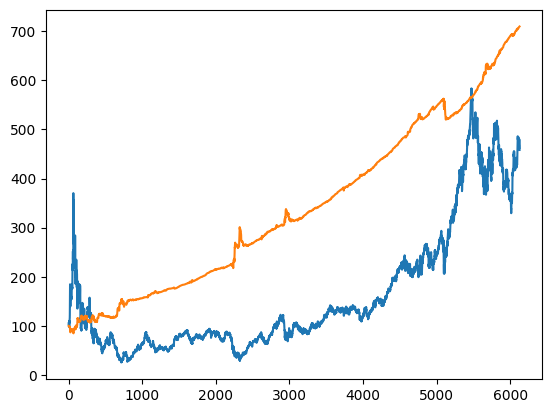

In [10]:
predict_percent = np.exp(predict)
target_percent = np.exp(target)
predict_plot = np.cumprod(predict_percent) * 100
target_plot = np.cumprod(target_percent) * 100
plt.plot(target_plot)
plt.plot(predict_plot)
plt.show()

In [11]:
total_profit = trade_test(predict,target)
print("total_profit : ",total_profit)
buy_and_hold_profit = trade_test(np.ones(target.shape),target)
print("buy and hold : ",buy_and_hold_profit)
random_profit = trade_test(np.random.randint(low=0,high=2,size=target.shape),target)
print("random profit : ",random_profit)

total_profit :  16.305177101289566
buy and hold :  4.5820224637360205
random profit :  9.597825179263143


[]

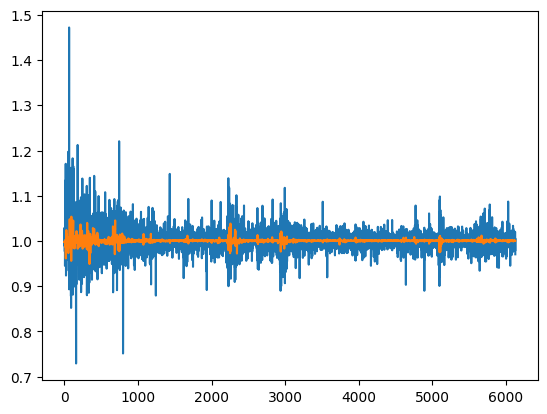

In [12]:
plt.plot(target_percent)
plt.plot(predict_percent)
plt.plot()

In [13]:
print(np.mean((np.log(np.array(target_percent)) * np.log(np.array(predict_percent))) > 0))

0.5208027410670583


In [14]:
plt.plot(learning_rates)
plt.show()

NameError: name 'learning_rates' is not defined